In [47]:
# Import base de torch
import torch
# Para las imagenes, obtener los datos de cifar
import torchvision
# Transformaciones para aplicar a los datos cuando se cargan
import torchvision.transforms as transforms

In [48]:
# Tamaño de la entra de la red, algunos modelos (resnet chi) funcionan con tamaño diferente, porque 
#   coincide nada más la primera capa convolucional de 3 canales (color), con otras no funciona.
input_size = 224

transformTrain = transforms.Compose([
        transforms.RandomResizedCrop(input_size), # Este hace un resize (corta no cambia tamaño), de manera aleatorio.
        transforms.RandomHorizontalFlip(), # Crear copias horizontales de la imagen.
        transforms.ToTensor(), # Pasarla a tensor.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Obligatorio para un modelo preentrenado.
    ])

transformTest = transforms.Compose([
        transforms.Resize(input_size), # Resize la imagen al tamaño
        transforms.CenterCrop(input_size), # Este no se pq segun yo ya tiene el tamaño por el anterior.
        transforms.ToTensor(), # Pasarla a tensor.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Obligatorio para un modelo preentrenado.
    ])

# Tamaño del batch, este habría que investigarlo mejor
batch_size = 16

# Obtener los datos de entrenamiento y prueba, aplicar las transformaciones.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transformTrain)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transformTest)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

# Nombres para las clases
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


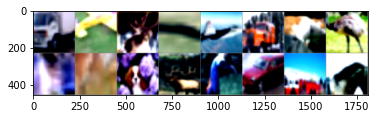

truck plane  deer horse plane truck   cat  bird  deer  deer   dog  deer  bird   car truck horse


In [49]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [50]:
# Modelo propio definido

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 100, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [51]:
# Escoger el coso para que corra, usar GPU o CPU, si no hay CPU esto revienta.
device = torch.device("cuda:0")
#device = torch.device("cpu")

print(device)

cuda:0


In [52]:
import torchvision.models as models

# Definir la red como la propia
# net = Net()

# Usar resnet18
net = models.resnet18(pretrained=True)
# Agarrar la última capa y cambiarle la salida, para que clasifique 10 clases.
net.fc = nn.Linear(512, 10)
# Cargar el modelo al GPU.
net.to(device)


# Optimizador y funcion de perdida, se inicializan con los parámetros de la red.
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [53]:
import time
start_time = time.time()

# Entrenamiendo, cantidad de epochs.
for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Obtener las entradas y las etiquetas, se pasan a cuda inmediatamente.
        inputs, labels = data[0].to(device), data[1].to(device)

        # Poner en cero los parámetros del gradiente.
        optimizer.zero_grad()

        # Pasada hacia delante.
        outputs = net(inputs)
        # Pasada hacia atrás.
        loss = criterion(outputs, labels)
        loss.backward()
        # Optimizar.
        optimizer.step()

        # Imprimir perdida por cada 2000 minibatches
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))

            # Reiniciar el loss, para la siguiente vuelta
            running_loss = 0.0

# Imprimir tiempo
print('Epochs terminados')
print("--- %s seconds ---" % (time.time() - start_time))

[1,  2000] loss: 1.018
[2,  2000] loss: 0.697
[3,  2000] loss: 0.635
[4,  2000] loss: 0.574
[5,  2000] loss: 0.549
[6,  2000] loss: 0.514
[7,  2000] loss: 0.510
[8,  2000] loss: 0.470
[9,  2000] loss: 0.476
[10,  2000] loss: 0.453
Finished Training
--- 998.0404667854309 seconds ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


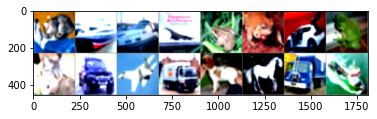

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship


In [54]:
# Agarrar un conjunto de imágenes para hacer una prueba rápida.
dataiter = iter(testloader)
images, labels = dataiter.next()

# Imprimir las imágenes y el groundtruth.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [55]:
# Hacer la pasada hacia delante de las imágenes anteriores.
outputs = net(images.to(device))
# Obtener las predicciones (los mayortes, porque es un vector de probabilidades).
_, predicted = torch.max(outputs, 1)

# Imprimir las predicciones.
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size)))

Predicted:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship


In [56]:
# Obtener un accuracy, para pruebas rápidas, para determinar que la red esté aprendiendo.
correct = 0
total = 0
# Desactivar el cálculo del grafo del gradiente, es solo para prueba, para que no afecte si se reentrena.
with torch.no_grad():
    # Iterar todas las imágenes de prueba
    for data in testloader:
        # Se obtienen las imágenes y las etiquetas, se pasan a cuda.
        images, labels = data[0].to(device), data[1].to(device)
        # Pasda hacia delante.
        outputs = net(images.to(device))
        # Obtener las predicciones (los mayortes, porque es un vector de probabilidades).
        _, predicted = torch.max(outputs.data, 1)
        # Sumar el total de muestras de 
        total += labels.size(0)
        # Sumar solo las correctas.
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 92 %


In [57]:
# Obtener un accuracy (POR CLASE), para pruebas rápidas, para determinar que la red esté aprendiendo.
# Es el mismo código de arriba, pero en una lista, se guardan totales por clase.
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size): # ¿4?
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 87 %
Accuracy of   cat : 84 %
Accuracy of  deer : 94 %
Accuracy of   dog : 88 %
Accuracy of  frog : 96 %
Accuracy of horse : 95 %
Accuracy of  ship : 96 %
Accuracy of truck : 95 %


In [59]:
# Imprimir la red, con esto me fijo en el modelo.
# Puedo ver la última capa, para saber como cambiarle la salida.
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [58]:
# Guardar el modelo.
#PATH = './cifar_net.pth'
#torch.save(net.state_dict(), PATH)

# Cargar el modelo.
# Esta linea de abajo debe coincidir con el modelo que voy a usar.
#   instancio el mismo modelo que guardé
# net = Net()
# net.load_state_dict(torch.load(PATH))